<a href="https://colab.research.google.com/github/TrzeciakPiotr2300/Uczenie_Maszynowe_2025/blob/main/HW10-convolutional-neural-network-CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reading MNIST Dataset
----------------------------------

In [1]:
import torch
import torchvision
from matplotlib import pyplot

transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 140MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 40.2MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 106MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.3MB/s]



## Definition of LeNet-5
Wiki definition [here](https://en.wikipedia.org/wiki/LeNet#/media/File:Comparison_image_neural_networks.svg).


In [2]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)  # With padding=2
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)  # Average pooling instead of max
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)  # No padding
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)  # Average pooling instead of max

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # Input size after conv and pooling: 16 feature maps of 5x5
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # Output: 10 classes (digits 0-9)

        # Dropout for regularization
        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):
        # First convolution block
        x = self.conv1(x)        # Convolution
        x = torch.sigmoid(x)     # Sigmoid activation
        x = self.pool1(x)        # Average Pooling

        # Second convolution block
        x = self.conv2(x)        # Convolution
        x = torch.sigmoid(x)     # Sigmoid activation
        x = self.pool2(x)        # Average Pooling

        # Flatten the output for the fully connected layers
        x = x.view(-1, 16 * 5 * 5)

        # Fully connected layers
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

# Training Loop
----------------------

In [ ]:
import random
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = LeNet5().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001.

losses = []
net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(18):  #  an epoch is a training run through the whole data set

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)  #explicitly moving the data to the target device
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the LeNet5 object. Please note,
                                            # the nonlinear activation after the last layer is NOT applied
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        losses.append(loss.item())
        if (batch % 30 == 0) or (batch % 30 == 10) or (batch == 20):
            print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.
                                ####You can experiment - comment this line and check, that the loss DOE

Working on cpu
epoch: 0 batch: 0 current batch loss: 2.3517048358917236
epoch: 0 batch: 10 current batch loss: 2.3083598613739014
epoch: 0 batch: 20 current batch loss: 2.3000619411468506
epoch: 1 batch: 0 current batch loss: 2.3030197620391846
epoch: 1 batch: 10 current batch loss: 2.298909902572632
epoch: 1 batch: 20 current batch loss: 2.2961525917053223
epoch: 2 batch: 0 current batch loss: 2.287325620651245
epoch: 2 batch: 10 current batch loss: 2.2550885677337646
epoch: 2 batch: 20 current batch loss: 2.158567428588867
epoch: 3 batch: 0 current batch loss: 1.9603601694107056
epoch: 3 batch: 10 current batch loss: 1.7365050315856934
epoch: 3 batch: 20 current batch loss: 1.5129574537277222
epoch: 4 batch: 0 current batch loss: 1.3150609731674194
epoch: 4 batch: 10 current batch loss: 1.1855666637420654
epoch: 4 batch: 20 current batch loss: 1.0972812175750732
epoch: 5 batch: 0 current batch loss: 1.0142402648925781
epoch: 5 batch: 10 current batch loss: 0.8923370838165283
epoch: 5

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

# Testing
----------------------

In [ ]:
good = 0
wrong = 0

net.eval()              #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation
with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1
        datapoint, label = data

        prediction = net(datapoint.to(device))                  #prediction has values representing the "prevalence" of the corresponding class
        classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

# Understanding Kernel Size, Stride and Padding

## Task: Designing a Convolutional Neural Network with a Target Receptive Field

Design a convolutional neural network using only 3×3 or 5×5 convolutional layers and 2×2 max-pooling layers without overlap (i.e., with stride 2). Use no padding in any layer. Insert a max-pooling layer after every two or three convolutional layers.

Your goal is to construct an architecture such that the receptive field of each output neuron is approximately 60×60 pixels.

Compute the receptive field size of the final output layer.

Compute the effective stride of the output layer with respect to the input.

Assuming an input image size of 400×400, determine the spatial size of the output feature map.

Q: Where would you locate ReLU layers?
Q: What if we can't match the desired input size with our architecture?
Q: Discuss what possible impact padding can have on the network performance.



# **Homework Assignment – Adversarial Examples. There will be two tasks**

In this assignment, you will explore how small (invisible to humans) changes to real digits can _fool_ the CNN into misclassifying them, even though the changes are imperceptible to humans.



## Task 1 – CNN Dreams: Last Homework Assignment Revisited


1. Starting from ten random noise images, optimize the input so that each image is classified with high confidence as one of the digits 0 through 9.
2. Include an **L2 penalty** on the input to keep the images visually closer to realistic digits. Use a range of penalty strengths (e.g., $\lambda_{l2}$ = 0, and then 0.01 through 10.0).
3. Compare the generated images (with and without L2 penalty) to those generated by the MLP:
   - Are they more or less readable?
   - Do they resemble real MNIST digits more closely or less?
   - Why do you think that happens? Consider the CNN’s inductive biases and architectural properties.

Use `cross_entropy_loss + lambda_l2 * input.pow(2).mean()` as your objective.

Reuse your code: visualize confidence evolution during optimization and generate image grids and (optionally) animations showing how the inputs evolve.




Working on cuda
Optimizing for lambda_l2 = 0 for 30000 epochs
  Epoch 0, Loss: 4.3027
  Epoch 3000, Loss: 0.0111
  Epoch 6000, Loss: 0.0077
  Epoch 9000, Loss: 0.0065
  Epoch 12000, Loss: 0.0060
  Epoch 15000, Loss: 0.0058
  Epoch 18000, Loss: 0.0057
  Epoch 21000, Loss: 0.0056
  Epoch 24000, Loss: 0.0056
  Epoch 27000, Loss: 0.0056
Optimizing for lambda_l2 = 0.01 for 28000 epochs
  Epoch 0, Loss: 3.9887
  Epoch 2800, Loss: 0.0209
  Epoch 5600, Loss: 0.0151
  Epoch 8400, Loss: 0.0112
  Epoch 11200, Loss: 0.0084
  Epoch 14000, Loss: 0.0072
  Epoch 16800, Loss: 0.0071
  Epoch 19600, Loss: 0.0071
  Epoch 22400, Loss: 0.0071
  Epoch 25200, Loss: 0.0071
Optimizing for lambda_l2 = 0.1 for 12000 epochs
  Epoch 0, Loss: 4.7482
  Epoch 1200, Loss: 0.1096
  Epoch 2400, Loss: 0.0849
  Epoch 3600, Loss: 0.0654
  Epoch 4800, Loss: 0.0484
  Epoch 6000, Loss: 0.0340
  Epoch 7200, Loss: 0.0231
  Epoch 8400, Loss: 0.0160
  Epoch 9600, Loss: 0.0125
  Epoch 10800, Loss: 0.0112
Optimizing for lambda_l2 = 

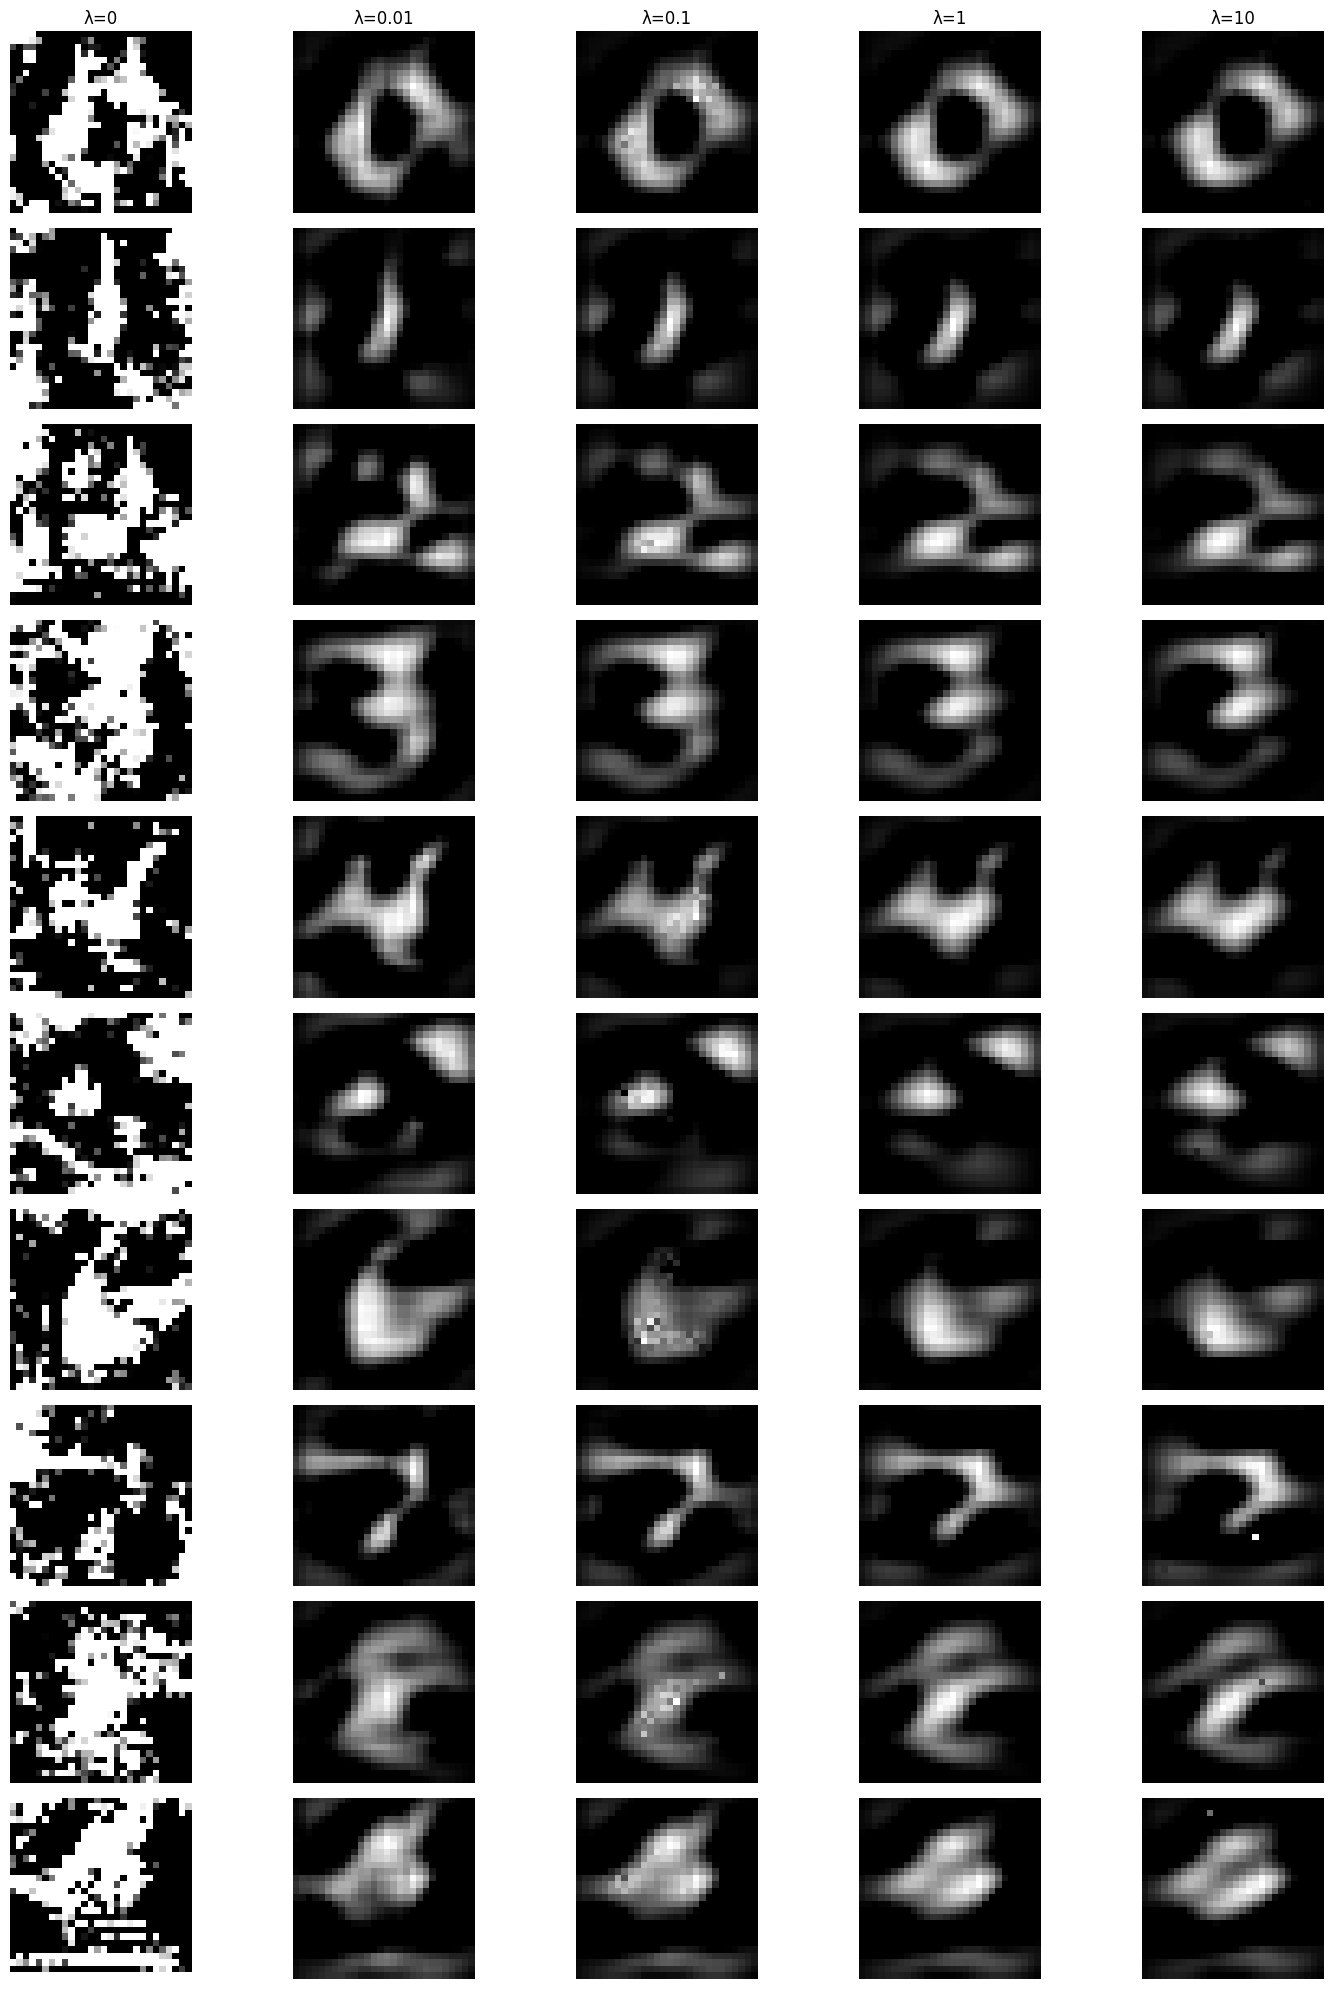

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")
net.eval()

# Hyper-Params
lambda_l2_list = [0, 0.01, 0.1, 1, 10]
epochs_list = [30000, 28000, 12000, 10000, 6000]  ## Optimal values via both:
                                                  ## Loss stabilises and doesn't go down any more
                                                  ## Images are resembling real numbers the most.

final_images_per_lambda = []

for lambda_l2, num_epochs in zip(lambda_l2_list, epochs_list):
    print(f"Optimizing for lambda_l2 = {lambda_l2} for {num_epochs} epochs")

    # Initialize noise (images)
    images = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)
    targets = torch.arange(10, device=device)

    optimizer = torch.optim.Adam([images], lr=0.001)

    # Epochs
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = net(images)
        loss = torch.nn.functional.cross_entropy(outputs, targets) + lambda_l2 * images.pow(2).mean()
        loss.backward()
        optimizer.step()
        if epoch % max(1, num_epochs // 10) == 0:
            print(f"  Epoch {epoch}, Loss: {loss.item():.4f}")

    # Saving reconstructed images
    final_images = images.detach().clamp(0, 1).cpu()
    final_images_per_lambda.append(final_images)

# Plotting
fig, axs = plt.subplots(10, 5, figsize=(15, 20))  # 10 cyfr, 5 lambd
for col, (lambda_l2, images) in enumerate(zip(lambda_l2_list, final_images_per_lambda)):
    for row in range(10):  # digit from 0 to 9
        axs[row, col].imshow(images[row][0], cmap='gray')
        if row == 0:
            axs[row, col].set_title(f"λ={lambda_l2}")
        axs[row, col].axis('off')
plt.tight_layout()
plt.show()


## Task 2 – Adversarial Examples: Fooling LeNet-5

This is the core focus of the assignment.

Using a batch of **real MNIST digits** (e.g., nine examples per class), craft **adversarial examples** by adding subtle, trained noise to the input images. Your goal is to:

- **Keep the human-perceived digit the same** (e.g., a "7" should still look like a "7"),
- But **cause LeNet-5 to misclassify it** – as every other class different from the original, hence nine examples per class.

### Objective
For each image $x$ and its true label $y$, learn a perturbation $\delta$ such that:

- $\text{LeNet5}(x + \delta) = y_{\text{wrong}} $,
- and $ \|\delta\|_2 $ is as small as possible (penalize large perturbations), to keep $x + \delta$ *look* like $x$ for humans.

### Optimization
Use gradient-based optimization on $\delta$ (the noise), while keeping the network weights frozen. Your loss might look like:

```
loss = cross_entropy(model(x + delta), target_wrong_class) +
       lambda_l2 * delta.pow(2).mean()
```

Tune the $\lambda_{l2}$ to find the best range.

### Deliverables for the Second Task
- Select some best examples, showing the original digit and its (correct) classification and the perturbed digit (hopefully, still looking the same to humans) and how it gets misclassified. Show them side by side.
- Report:
  - Success rate of attacks (it doesn't need to be very formal),
  - Effect of $\lambda_{l2}$ on visibility of the noise and success of misclassification,
  - Example image grids and confidence plots.


In [ ]:
## Initialising noise that we'll train to get missclasification for our net
delta = torch.randn((1, 1, 28, 28), device=device, requires_grad=True)
optimizer = torch.optim.Adam([delta], lr=0.001)
net.eval()

for epoch in range(1000):
    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data
        loss = torch.nn.functional.cross_entropy(net(batch_inputs + delta), batch_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

## Let's take a look at delta:
